In [275]:
import numpy as np

class Input:
	# input shape: (batch_size, #features)
	# output shape: (batch_size, #features)

	def __init__(self, inputFeatures) -> None:
		self.inputShape = (-1, inputFeatures)
		self.outputShape = self.inputShape

	def forward(self, x):
		return x

	def backward(self, gradientLossWRTOutput, _):
		return gradientLossWRTOutput, None

	def getWeights(self):
		return None



class Dense:
	# input shape: (batch_size, #features)
	# output shape: (batch_size, #nodes)

	def __init__(self, numNodes) -> None:
		self.numNodes = numNodes

	# input shape: (batch_size, #features)
	def initPipeline(self, inputShape):
		inputFeatures = inputShape[1]
		self.features = inputFeatures

		# self.weights = np.random.randn(self.numNodes, inputFeatures)
		self.weights = np.random.uniform(-.3, .3, (self.numNodes, inputFeatures))

		# self.weights = np.ones((self.numNodes, inputFeatures))
		# print(self.weights.shape)
		# self.bias = np.random.randn(self.numNodes, 1)
		self.bias = np.random.uniform(-.3, .3, (self.numNodes, 1))

		# self.bias = np.ones((self.numNodes, 1))
		# print(self.bias.shape)
		self.outputShape = (-1, self.numNodes)

	# x shape: (batch_size, #features)
	def forward(self, x):
		self.x = x
		self.y = np.dot(self.weights, x.T) + self.bias
		self.y = self.y.T
		return self.y

	# gradientLossWRTOutput shape: (batch_size, #nodes)

	def backward(self, gradientLossWRTOutput,optimizer):

		gradientLossWRTInput = np.dot(gradientLossWRTOutput, self.weights)


		gradientLossWRTWeights = np.dot(gradientLossWRTOutput.T, self.x)
		gradientLossWRTBias = np.sum(gradientLossWRTOutput, axis = 0, keepdims=True).T

		# print(f"gradientLossWRTWeights : {gradientLossWRTWeights.shape}")
		# print(f"gradientLossWRTbias : {gradientLossWRTBias.shape}")


		self.weights = optimizer.update(self.weights, gradientLossWRTWeights)
		self.bias = optimizer.update(self.bias, gradientLossWRTBias)

		# self.weights -= learningRate * gradientLossWRTWeights
		# self.bias -= learningRate * gradientLossWRTBias

		return gradientLossWRTInput, (gradientLossWRTWeights, gradientLossWRTBias)

	def getWeights(self):
		return (self.weights, self.bias)



class Softmax:
	def __init__(self) -> None:
		pass

	# input shape: (batch_size, #features)
	# output shape: (batch_size, #features)

	def initPipeline(self, inputShape):
		self.inputShape = inputShape
		self.outputShape = inputShape

	def forward(self, x):
		self.x = x
		# print(self.x)
		# print(np.max(self.x))
		self.y =  np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
		return self.y

	# gradientLossWRTOutput shape: (batch_size, #features)

	def backward(self, gradientLossWRTOutput, _):
		# gradientOutputWRT

		n , m = self.y.shape

		gradientOutputWRTInput = np.repeat(self.y, m, axis=0).reshape(n, m, m)
		gradientOutputWRTInput = np.multiply(gradientOutputWRTInput, np.transpose(gradientOutputWRTInput, axes=(0, 2, 1))) * -1

		diagElems = np.reshape(self.y, (n,  m , 1))
		diagElems = diagElems * (1 - diagElems)
		diagElems = np.eye(m) * diagElems
		mask = np.eye(m, dtype=bool)
		mask = np.tile(mask, (n, 1)).reshape(n, m, m)
		gradientOutputWRTInput[mask] = 0
		gradientOutputWRTInput = gradientOutputWRTInput + diagElems

		# jacobian_matrix = np.zeros((n, m, m))

		# for i in range(n):
		# 	# s = np.exp(self.x[i]) / np.sum(np.exp(self.x[i]), axis=1, keepdims=True)
		# 	s = self.y[i]
		# 	for j in range(n):
		# 		for k in range(n):
		# 			jacobian_matrix[i, j, k] = s[j] * (int(j == k) - s[k])


		# print(np.isclose(jacobian_matrix, gradientOutputWRTInput).all())
		# print(f"gradientLossWRTOutput : {np.expand_dims(gradientLossWRTOutput, -1).shape}")


		gradientLossWRTInput = np.matmul(gradientOutputWRTInput, np.expand_dims(gradientLossWRTOutput, -1))
		gradientLossWRTInput = np.squeeze(gradientLossWRTInput)

		# print(f"gradientLossWRTInput : {gradientLossWRTInput.shape}")

		return gradientLossWRTInput, None

	def getWeights(self):
		return None


class Relu:

	def __init__(self) -> None:
		pass

	def initPipeline(self, inputShape):
		self.inputShape = inputShape
		self.outputShape = inputShape

	def forward(self, x):
		self.x = x
		self.y = np.maximum(x, 0)
		return self.y

	# gradientLossWRTOutput shape: (batch_size, #features)
	def backward(self, gradientLossWRTOutput, _):
		gradientOutputWRTInput = np.where(self.x > 0, 1, 0)
		gradientLossWRTInput = np.multiply(gradientOutputWRTInput, gradientLossWRTOutput)
		return gradientLossWRTInput, None

	def getWeights(self):
		return None



class Model:
	EPSILON = .000001
	def __init__(self, *layers) -> None:
		self.nLayers = len(layers)

		for i in range(1, self.nLayers):
			layers[i].initPipeline(layers[i-1].outputShape)

		self.layers = layers

	def predict(self, x):
		for layer in self.layers:
			x = layer.forward(x)
		return x

	def crossEntropyGradient(self, yTrue, yPred):
		ypc = yPred.copy()
		ypc[ypc < Model.EPSILON] = Model.EPSILON
		return - yTrue / ypc

	def __backprop(self,yTrue, yPred, optimizer):
		gradientLossWRTOutput = self.crossEntropyGradient(yTrue, yPred)
		# gradientLossWRTOutput = self.squaredErrorGradient(yTrue, yPred)
		# print(gradientLossWRTOutput)

		# print(f"loss grad wrt yhat : {gradientLossWRTOutput.shape}")
		# wAndg = []
		for layer in reversed(self.layers):
			gradientLossWRTOutput, g = layer.backward(gradientLossWRTOutput, optimizer)
			# wAndg.append((layer.getWeights(), g))


	def crossEntropyLoss(self, yPred, yTrue):
		ypc = yPred.copy()
		ypc[ypc < Model.EPSILON] = Model.EPSILON
		return -np.sum(yTrue * np.log(ypc))


		# return wAndg

	def train(self, x, y, optimizer, epoch, batchSize):
		for i in range(epoch):
			numExa = x.shape[0]

			xy = list(zip(x, y))
			np.random.shuffle(xy)

			x, y = zip(*xy)
			x = np.array(x)
			y = np.array(y)

			numExa = x.shape[0]
			numBatches = numExa // batchSize
			remSamples = numExa % batchSize

			xB = np.array_split(x[:numBatches * batchSize], numBatches)
			yB = np.array_split(y[:numBatches * batchSize], numBatches)

			if remSamples > 0:
				xB.append(x[-remSamples:])
				yB.append(y[-remSamples:])
				numBatches += 1

			for i in range(numBatches):
				xc = xB[i]
				yc = yB[i]

				yPred = self.predict(xc)
				# print(yPred)
				# loss = self.__loss(y, yPred)
				# print(f"epoch {i} : {loss}")
				self.__backprop(yc, yPred, optimizer)

				print(f"loss : {self.crossEntropyLoss(yc, yPred)}")


	def squaredErrorGradient(self, yTrue, yPred):
		return -2 * (yTrue - yPred)




class GradientDescent:
	def __init__(self, learningRate) -> None:
		self.learningRate = learningRate

	def update(self, w, g):
		return w - self.learningRate * g


def eqn(x):
	return 2 * (x[0] ** 2) + 3.5 * x[1] + 7

def main():

	xs = []
	ys = []
	for i in range(100):
		x = np.random.randn(2)
		xs.append(x)
		ys.append(eqn(x))
	x = np.vstack(xs)
	y = np.vstack(ys)

	print(x.shape)
	print(y.shape)



	model = Model(
		Input(2),
		Dense(4),
		Relu(),
		Dense(3),
		Relu(),
		Dense(1)
		# Dense(3),
		# Dense(2),
		# Softmax()
		# Softmax()
	)
	# print(model.predict(x))
	# x = np.array([[1, -3], [-1, 1], [5, 6]])
	# y = np.array([[0, 1, 0], [1, 0, 0], [0,0, 1]])
	# print(x.shape)
	# yPred = model.predict(x)
	# print(f"ypred : {yPred}")
	# print(f"yPred.shape : {yPred.shape}")
	xt = np.array([[.5, .36]])

	# print(model.predict(xt))
	# print(eqn(xt[0]))

	print(np.sum(np.square(model.predict(x) - y)) / 100)

	model.train(x, y, GradientDescent(0.0001), 1000)

	print(np.sum(np.square(model.predict(x) - y)) / 100)




	print(model.predict(xt))
	print(eqn(xt[0]))
	# print(model.predict(x))



In [144]:
import torchvision.datasets as ds
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [2]:
train = ds.EMNIST(root = '/content/', split = 'letters', train = True, transform = transforms.ToTensor(), download = True)

100%|██████████| 561753746/561753746 [00:10<00:00, 51450151.91it/s]


Extracting /content/EMNIST/raw/gzip.zip to /content/EMNIST/raw


In [145]:
train

Dataset EMNIST
    Number of datapoints: 124800
    Root location: /content/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [48]:
(train.targets == 26).any()

tensor(True)

In [5]:
train.data.shape

torch.Size([124800, 28, 28])

In [ ]:
train.data[0]

In [63]:
encoder = OneHotEncoder(sparse=False)
oneHotEncoded = encoder.fit_transform(np.expand_dims(train.targets, -1))
# print(one_hot_encoded.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [149]:
tX, vX, tY, vY = train_test_split(train.data, oneHotEncoded, test_size = .6, random_state = 29)

In [150]:
tX.shape

torch.Size([49920, 28, 28])

In [151]:
tY.shape

(49920, 26)

In [67]:
def plot(img):
  plt.imshow(img, cmap = 'gray')
  plt.show()

In [68]:
def randomPlot(x, y):
  num_images = x.shape[0]
  indices = np.random.choice(num_images, 16, replace=False)

  # Plotting 16 random images
  plt.figure(figsize=(8, 8))
  for i, index in enumerate(indices, 1):
      plt.subplot(4, 4, i)
      plt.imshow(x[index], cmap='gray')
      plt.title(f"{chr(np.argmax(y[index]) + ord('a') )}", fontsize=10)
      plt.axis('off')

  plt.tight_layout()
  plt.show()

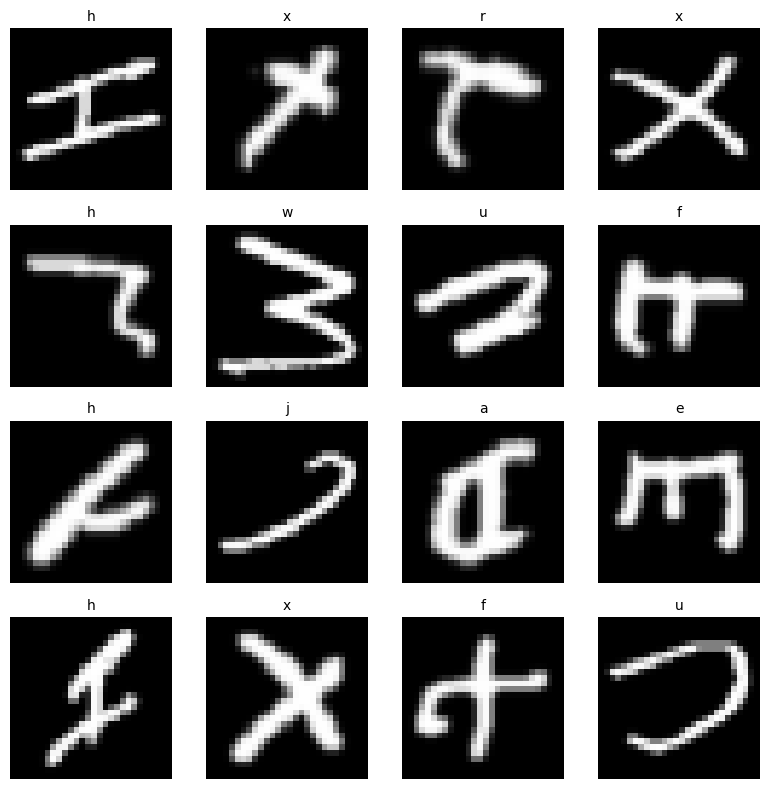

In [152]:
randomPlot(tX, tY)

In [279]:
def acc(model, x, yTrue):
  yPred = model.predict(x)
  yPred = np.argmax(yPred, axis = 1)
  yTrue = np.argmax(yTrue, axis = 1)
  return accuracy_score(yTrue, yPred)

In [281]:
np.random.seed(13)
x = np.copy(tX)
y = np.copy(tY)

numExamples = x.shape[0]
x = np.reshape(x, (numExamples, -1))
print(x.shape)
numFeatures = x.shape[1]

model = Model(
    Input(numFeatures),
    Dense(256),
    Relu(),
    Dense(128),
    Relu(),
    Dense(64),
    Relu(),
    Dense(32),
    Relu(),
    Dense(26),
    Softmax()
)


n = x.shape[0]
xs = x[0:n] / 255
ys = y[0:n]

print(acc(model, xs, ys))

model.train(xs,ys, GradientDescent(.001), 10, 256)

print(acc(model, xs, ys))

(49920, 784)
0.03467548076923077
loss : 3419.031401347758
loss : 3420.2485584043993
loss : 3407.576298041206
loss : 3395.7027579551195
loss : 3396.204833644987
loss : 3399.9808198697438
loss : 3393.3117222745364
loss : 3400.742251747944
loss : 3399.5128278379902
loss : 3400.5679941865897
loss : 3396.3948162468114
loss : 3396.0041389125786
loss : 3396.9712744761227
loss : 3396.5428476663155
loss : 3395.9634561767593
loss : 3409.124288159034
loss : 3443.1734800862073
loss : 3400.222905513132
loss : 3399.606420035134
loss : 3396.2134537876263
loss : 3398.6286415256973
loss : 3400.119342862719
loss : 3402.318678476288
loss : 3400.641713300508
loss : 3400.3982801627335
loss : 3393.911879618974
loss : 3399.636798275131
loss : 3397.299380044395
loss : 3394.504335784446
loss : 3398.680600948853
loss : 3391.7404174979156
loss : 3392.77607925003
loss : 3395.5732272265823
loss : 3376.2874552181065
loss : 3392.9798276828005
loss : 3389.158431438288
loss : 3381.7758545687334
loss : 3398.80704078355

In [282]:
print(acc(model, np.reshape(vX, (vX.shape[0], -1)) / 255, vY ))

0.8435496794871795


In [268]:
.0 * np.exp(1000)

<ipython-input-268-9da1953d9d6a>:1: RuntimeWarning: overflow encountered in exp
  .0 * np.exp(1000)
<ipython-input-268-9da1953d9d6a>:1: RuntimeWarning: invalid value encountered in double_scalars
  .0 * np.exp(1000)


nan

In [253]:
yPred =  model.predict(x / 255)
yPred = np.argmax(yPred, 1)
accuracy_score(yTrue, yPred)

4.906803534523321


ValueError: ignored

7.239103122634079


0.029467147435897435

In [243]:
n = 1000
xs = x[0:n]
ys = y[0:n]

In [248]:
model.train(xs / 255.,ys, GradientDescent(.0001), 1, 256)

nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
loss : nan
nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
loss : nan
nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
loss : nan
nan
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
loss : nan


<ipython-input-241-fa3eaf1002d4>:195: RuntimeWarning: divide by zero encountered in log
  return -np.mean(yTrue * np.log(yPred))


In [245]:
model.predict(x[0] / 255.)

15.441225793984904


array([[9.64196872e-04, 4.36235994e-09, 8.61792079e-04, ...,
        2.20580202e-08, 3.11272512e-02, 5.31570266e-03],
       [2.56509971e-02, 6.85556669e-04, 2.63567954e-02, ...,
        1.00783256e-03, 8.29320561e-02, 5.45343356e-02],
       [1.58918968e-02, 6.54861973e-05, 1.58530629e-02, ...,
        1.27993558e-04, 8.60837071e-02, 4.13998095e-02],
       ...,
       [4.34255141e-02, 3.71269625e-02, 2.68246024e-02, ...,
        4.00804187e-02, 3.71267259e-02, 4.98456457e-02],
       [2.67300361e-05, 1.06345797e-13, 2.13174387e-05, ...,
        1.43278060e-12, 5.44088365e-03, 3.19783847e-04],
       [3.67652439e-02, 2.94144052e-02, 3.19929873e-02, ...,
        2.92797833e-02, 4.70056717e-02, 4.94279541e-02]])

In [115]:
xy = list(zip(x, y))
np.random.shuffle(xy)

# Separate shuffled images and labels
x, y = zip(*xy)
x = np.array(x)
y = np.array(y)

batchSize = 64
numExa = x.shape[0]
numBatches = numExa // batchSize
remSamples = numExa % batchSize


xB = np.array_split(x[:numBatches * batchSize], numBatches)
yB = np.array_split(y[:numBatches * batchSize], numBatches)


if remSamples > 0:
  xB.append(x[-remSamples:])
  yB.append(y[-remSamples:])
  numBatches += 1


In [116]:
xB[0].shape

(64, 784)

In [ ]:
randomPlot(np.reshape(xB[0], (batchSize, 28, 28)), yB[0])